# Star Separation Test

### Motivation 

A notebook to test the performance of comcam close loop (estimation of Zernike polynomials from the Wavefront Estimation Calculation pipeline) as the simulated stars are brought closer together,  possibly bringing us to the regime of overlapping donuts. 

### Performance Metric 

The RMS value between OPD results and the Zernike polynomials given by ts_wep output.

### Test Data 

Created on UW *epyc*, in `ts_phosim/notebooks/analysis_scripts/output/` running `runSeparationAnalysis.py` in the `ts_phosim/notebooks/analysis_scripts` directory.


## Setup 

In [1]:
%load_ext autoreload
%autoreload 2
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

In [3]:
FilterType?

Init signature:
FilterType(
    value,
    names=None,
    *,
    module=None,
    qualname=None,
    type=None,
    start=1,
)
Docstring:      An enumeration.
File:           /astro/store/epyc/projects/lsst_comm/ts_wep/python/lsst/ts/wep/Utility.py
Type:           EnumMeta
Subclasses:     


In [4]:
# to reload PhosimCmpt after some code editing,
# need to run the code below - 
# it tells python to removes the name binding. 
# Python only searches sys.modules to see whether 
# the modules had already been imported,
# and if they had, they are not reloaded 
import sys
del sys.modules['lsst.ts.wep.Utility']

#N.B.  
#import imp
#imp.reload(module)
# works only for modules, not classes! 

from lsst.ts.wep.Utility import FilterType



In [5]:
FilterType?


Init signature:
FilterType(
    value,
    names=None,
    *,
    module=None,
    qualname=None,
    type=None,
    start=1,
)
Docstring:      An enumeration.
File:           /astro/store/epyc/projects/lsst_comm/ts_wep/python/lsst/ts/wep/Utility.py
Type:           EnumMeta
Subclasses:     


In [10]:


import os
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import argparse

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

import matplotlib.pyplot as plt
import matplotlib.cm as cm 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.21000000000000002
0.18500000000000003
0.16000000000000003
0.135
0.11
0.085
0.060000000000000005
0.035
0.01


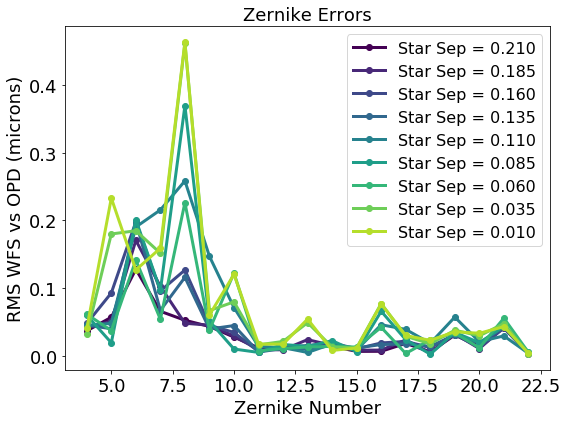

In [35]:
%matplotlib inline

data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'




ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()

sepArr = np.arange(0.01, 0.23, 0.025 )[::-1]

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 


for sep in sepArr :
    print(sep)
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.sep.%.3f'%sep)
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.sep.%.3f'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.3f' % sepArr[i],color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors', size=18)
    
plt.tight_layout()

This picture from https://www.janssenprecisionengineering.com/wp-content/uploads/Zernike_modes_adapted.png illustrates which optical distortions these Zernikes correspond: 
    <img src='Zernike_modes_adapted.png'></img>

Show what the images look like for each separation:


In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import IFrame, display, Markdown, HTML
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay

from lsst.geom import Extent2D, Point2D, SpherePoint
from lsst.geom import degrees as geomDeg

First display the raw image  for separation 0.11 degrees :

In [442]:
sep = 0.06
obsId = 9006001
detectors = ['S00', 'S01', 'S02','S10', 'S11', 'S12', 'S20', 'S21', 'S22']
detector = detectors[0]


outDir = 'output/sep_%.3f/'%sep
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'+outDir
repo_dir = os.path.join(data_dir, 'input')

#Initialize the butler in the raw image repository:
butler = dafPersist.Butler(repo_dir)

# open the raw image 
data_id = {'visit': obsId, 'filter': 'g', 'raftName': 'R22', 'detectorName': detector}
raw = butler.get ('raw', **data_id)  # doesn't show anything ...  ? 




Ignoring Error calculating property 'boresight_airmass' using translator <class 'lsst.obs.lsst.translators.phosim.PhosimTranslator'>: "Could not find ['AIRMASS'] in header"
Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.lsst.translators.phosim.PhosimTranslator'>: "Could not find ['TEMPERA'] in header"
Ignoring Error calculating property 'pressure' using translator <class 'lsst.obs.lsst.translators.phosim.PhosimTranslator'>: "Could not find ['PRESS'] in header"


In [422]:
# helper funtion for the colorbar 
# from https://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

Text(0.5, 1.0, 'raw image, separation 0.060 degrees')

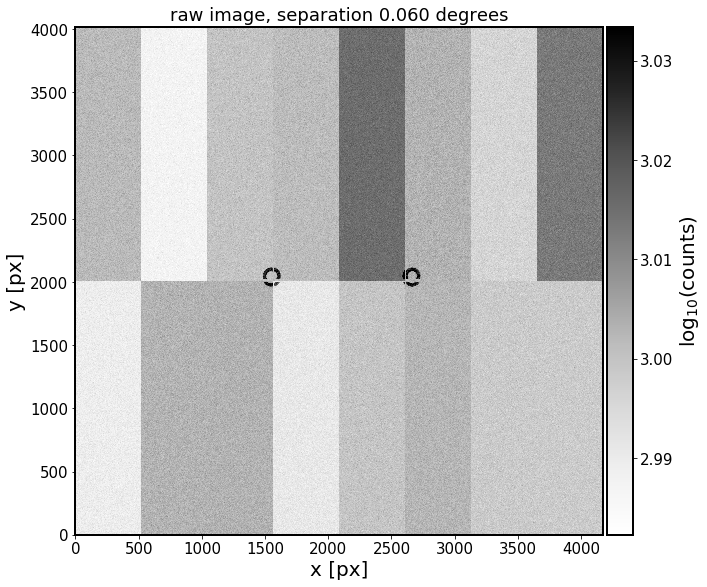

In [443]:
# Plot image array
fig,ax = plt.subplots(1,1,figsize=(10,10))

img = ax.imshow(np.log10(raw.image.array),vmin = np.log10(960), 
           vmax=np.log10(1080), cmap=cm.get_cmap('Greys'),
          origin='lower')
cbar= colorbar(mappable=img)
cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$',weight='normal', )
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('raw image, separation %.3f degrees'%sep)

Show the cutout of the raw donut (source detection doesn't work well on raw images since donut appears 'split' between different amps, so I select image region by hand below : ')

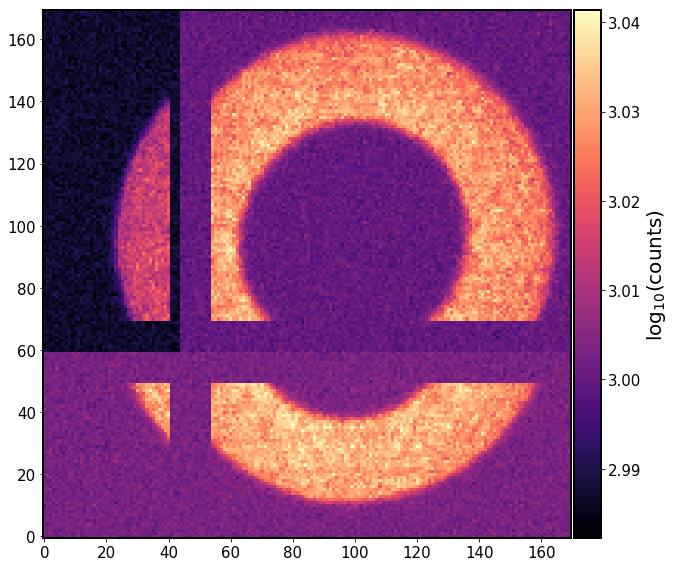

In [430]:
xmin,xmax = 1000,1170
ymin,ymax = 1950,2120
# Plot image array
fig,ax = plt.subplots(1,1,figsize=(10,10))

left,bottom,width,height = .95, 0.12, 0.03, 0.76

    
img = ax.imshow(np.log10(raw.image.array[ymin:ymax, xmin:xmax]),vmin = np.log10(960), 
           vmax=np.log10(1100), cmap=cm.get_cmap('magma'),
          origin='lower')
cbar= colorbar(mappable=img)
cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )


Now show  the postISR CCD (after the instrument signature removal pipeline was run):

In [516]:
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/output/sep_0.110/'
repo_dir = os.path.join(data_dir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)

# show what keys are needed 
# by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int,
# 'filter': str,
# 'raftName': str,
# 'detectorName': str,
# 'detector': int}
detNum = 90
data_id = {'visit': obsId, 'filter': 'g', 'raftName': 'R22', 'detectorName': detector, 'detector': detNum}
post = butler.get('postISRCCD', **data_id)  # doesn't show anything ...  ? 

/astro/store/epyc/projects/lsst_comm/new_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


Text(0.5, 1.0, 'postISR image, separation 0.110 degrees')

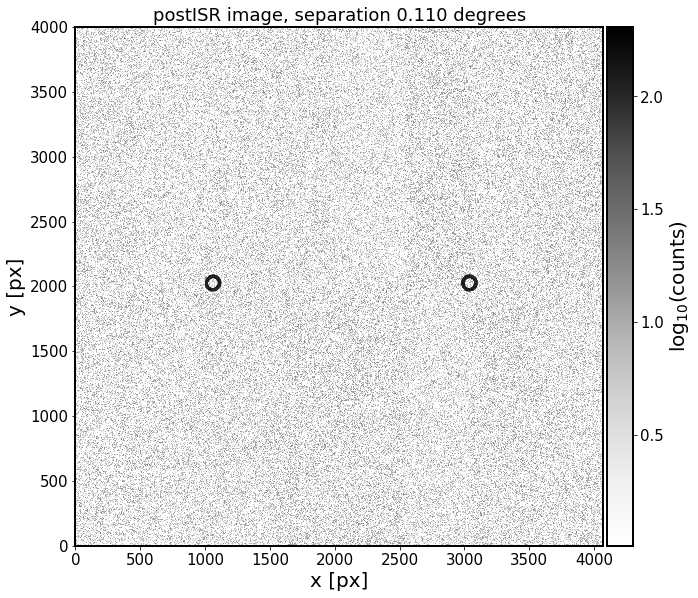

In [434]:
%matplotlib inline
# Plot image array

fig,ax = plt.subplots(1,1,figsize=(10,10))

img = ax.imshow(np.log10(post.image.array), vmin = 0.01,cmap=cm.get_cmap('Greys'),
          origin='lower')
cbar= colorbar(mappable=img)
cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('postISR image, separation %.3f degrees'%sep)



Manual selection of x,y position is fine...

Text(0, 0.5, 'y [px]')

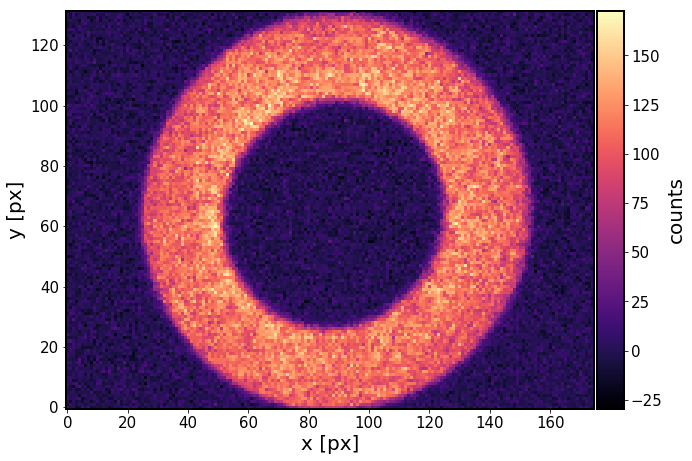

In [524]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
# xmin,xmax = 500,1500
# ymin,ymax = 1000,2500
xmin,xmax = 975,1150
ymin,ymax = 1962,ymin+132

# Plot image array
fig,ax = plt.subplots(1,1,figsize=(10,10))
img = ax.imshow(post.image.array[ymin:ymax, xmin:xmax],
                  cmap=cm.get_cmap('magma'),origin='lower')

cbar  = colorbar(img)
cbar.set_label(label='counts',weight='normal', )

ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

We can do better - run the quick source detection using `lsst.meas.algorithms.detection.SourceDetectionTask` (following https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_notebooks/detect_sources.ipynb ) 

In [440]:
# set up minimal detection task
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 50   # detection threshold in units of thresholdType
config.thresholdType = "value"#"stdev"   # units for thresholdValue

sourceDetectionTask = SourceDetectionTask(config=config)

footprint_set = sourceDetectionTask.detectFootprints(post, sigma=1.)

f_set_pos = footprint_set.positive

f_prints = f_set_pos.getFootprints()

# print source centroids ...
source_centroids = [fp.getCentroid() for fp in f_prints]
print(source_centroids)


# make the footprint 'heavy' to be able to print postage stamps...
f_set_pos.makeHeavy(post.getMaskedImage())

# redefine the footprint set 
hfps = f_set_pos.getFootprints() 


[Point2D(1064.049763, 2026.642758), Point2D(3041.619967, 2026.719506)]


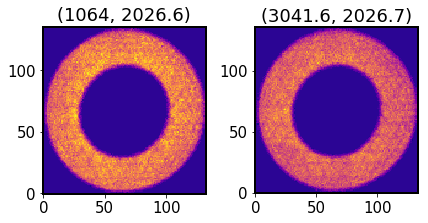

In [441]:
# plot the detections

fig = plt.figure(figsize=(12,12))
for idx in range(len(f_prints)):
    fig.add_subplot(4,4,idx+1)
    plt.imshow(f_prints[idx].getSpans().unflatten(hfps[idx].getImageArray()),
           cmap='plasma', origin='lower')
    plt.title(source_centroids[idx])
plt.tight_layout()

These are two detected donuts 

## Test separation on a single amplifier 

In [534]:
sepArr = np.array([80,60,40,20]) # % of the size of the amplifier 
amplifierSpanPx = 2048 # in pixels
donutPxRadius = 66 # in pixels 
sepInPx = sepArr*0.01*amplifierSpanPx
sepInRadii = sepInPx / donutPxRadius  # convert separation to units of donut radii 

In [535]:
sepInRadii

array([24.82424242, 18.61818182, 12.41212121,  6.20606061])

8
5
4
3
2
1


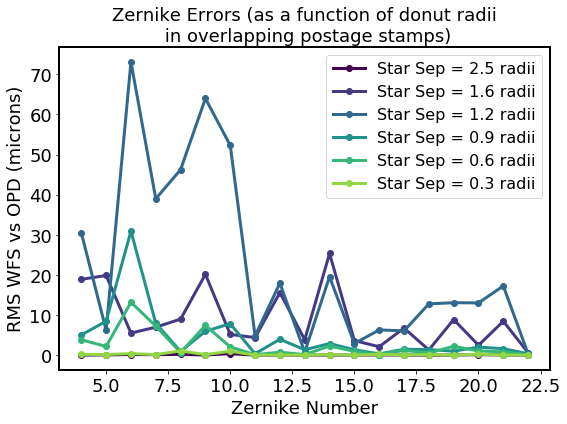

In [545]:
%matplotlib inline

baseDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_before_centroid_update'
resDir = 'singleAmp'
data_dir = os.path.join(baseDir, topDir,resDir)




ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()

#sepArr = [80,60,40,20,15,10,8]#,
sepArr = [8,5,4,3,2,1]
#sepArr = [3,2,1]

yPxAmp = 2048 # in pixeels
donutPxRadius = 66 # px 

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 


for sep in sepArr :
    print(sep)
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    sepInPx = sepArr[i]*0.01*yPxAmp
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.1f radii' % (sepInPx / donutPxRadius),color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of donut radii\n in overlapping postage stamps)', size=18)
    
plt.tight_layout()
plt.savefig('StarSep_singleAmp_16mag_vary_separation_rms_wfs_vs_opd_overlapping2_in_donut.png', 
            bbox_inches='tight', 
           dpi=100)

In [548]:
np.arange(1,11)[::-1]

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [556]:
topDir = 'results_after_centroid_update'
expDir = 'singleAmpSep'
starSep = 5
outputDir = os.path.join(topDir,expDir,'sep_%d' % starSep)
outputDir

'results_after_centroid_update/singleAmpSep/sep_5'

In [560]:
skyFilePath = os.path.join(topDir,expDir,'starCat_%d.txt'%starSep)
skyFilePath

'results_after_centroid_update/singleAmpSep/starCat_5.txt'

In [559]:
argString = '-a '+os.path.join(topDir,expDir,'sep_10')+'/. '+ outputDir+'/'
argString

'-a results_after_centroid_update/singleAmpSep/sep_10/. results_after_centroid_update/singleAmpSep/sep_5/'

How do these stars look like ? (post-ISR)

In [461]:
sep = sepArr[3]
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_%d/'%sep
print('Reading data from \n')
print(data_dir)
repo_dir = os.path.join(data_dir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)

# show what keys are needed 
# by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int,
# 'filter': str,
# 'raftName': str,
# 'detectorName': str,
# 'detector': int}
detNum = 90
data_id = {'visit': obsId, 'filter': 'g', 'raftName': 'R22', 'detectorName': detector, 'detector': detNum}
post = butler.get('postISRCCD', **data_id)  # doesn't show anything ...  ? 

Reading data from 

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_3/


/astro/store/epyc/projects/lsst_comm/new_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log10


Text(0.5, 1.0, 'postISR image, separation 1 % of amplifier span')

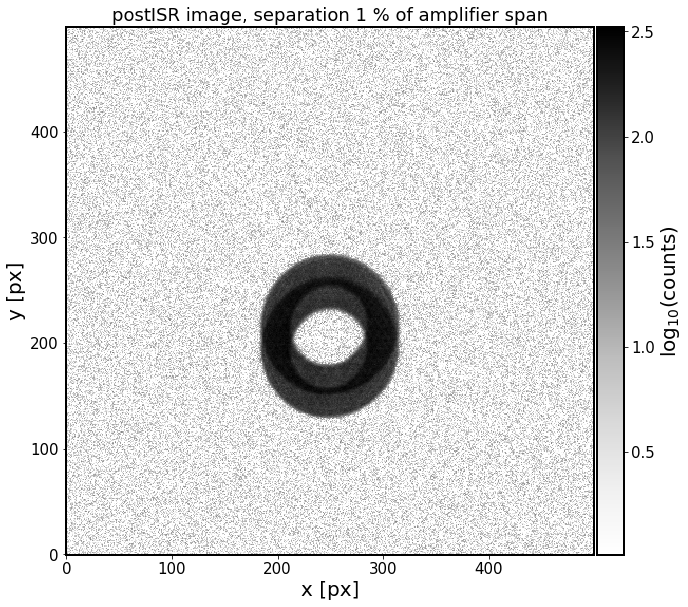

In [476]:
%matplotlib inline
# Plot image array

fig,ax = plt.subplots(1,1,figsize=(10,10))

xmin,xmax = 1525,2025
ymin,ymax = 750,1250

img = ax.imshow(np.log10(post.image.array[ymin:ymax, xmin:xmax]), vmin = 0.01,cmap=cm.get_cmap('Greys'),
          origin='lower')
cbar= colorbar(mappable=img)
cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('postISR image, separation %d %% of amplifier span'%sep)



Plot both the Zernikes and the postage stamp : 

In [494]:
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'


# Read in the Zernike comparison between wfs and opd 
# for this list of separatoins: 

#sepArr = [80,60,40,20,15,10,8,5,4,3,2,1]
sepArr = [10,8,5,4,3,2,1]


# initialize metrics class 
calcMagMetrics = calcMetrics()

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

# initialize storage arrays 
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
    
for sep in sepArr :

    print(sep)
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))



10
8
5
4
3
2
1


In [465]:
# Read each figure as a postage stamp, store data to an array 
images = {}
for sep in sepArr:
    data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_%d/'%sep
    print('\nReading data from')
    print(data_dir)
    repo_dir = os.path.join(data_dir, 'input/rerun/run1')
    butler = dafPersist.Butler(repo_dir)

    # show what keys are needed 
    # by the `postISRCCD` data type.... 
    # butler.getKeys('postISRCCD')
    # yields {'visit': int,
    # 'filter': str,
    # 'raftName': str,
    # 'detectorName': str,
    # 'detector': int}
    detNum = 90
    data_id = {'visit': obsId, 'filter': 'g', 'raftName': 'R22', 'detectorName': detector, 'detector': detNum}
    post = butler.get('postISRCCD', **data_id) 
    
    # store in a dictionary
    images[sep] = post.image.array
    
    

Reading data from 

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_10/
Reading data from 

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_8/
Reading data from 

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_5/
Reading data from 

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_4/
Reading data from 

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_3/
Reading data from 

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_2/
Reading data from 

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_1/


In [466]:
for i in range(1):
    print(i)

0


/astro/store/epyc/projects/lsst_comm/new_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in log10


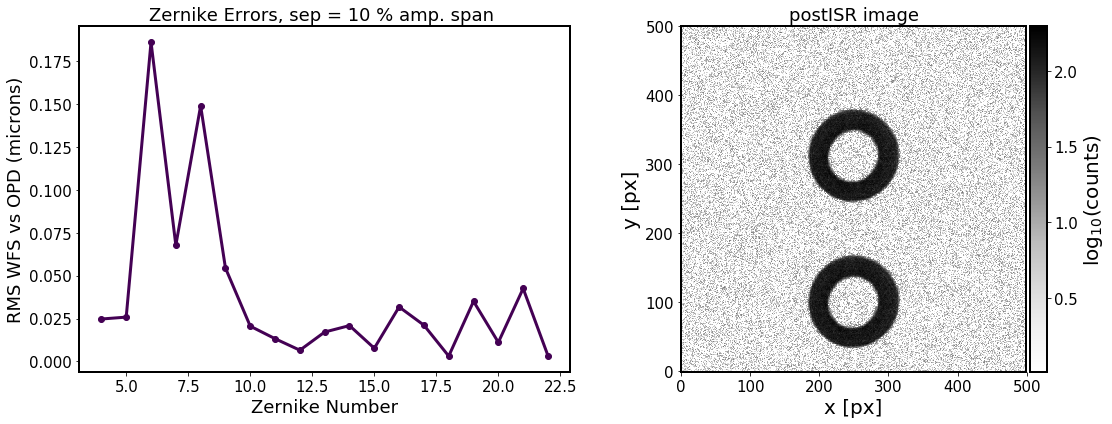

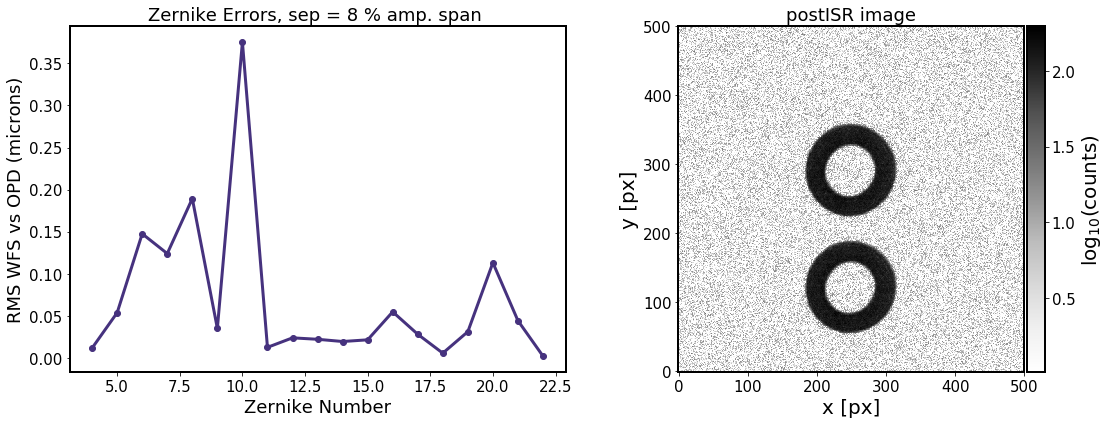

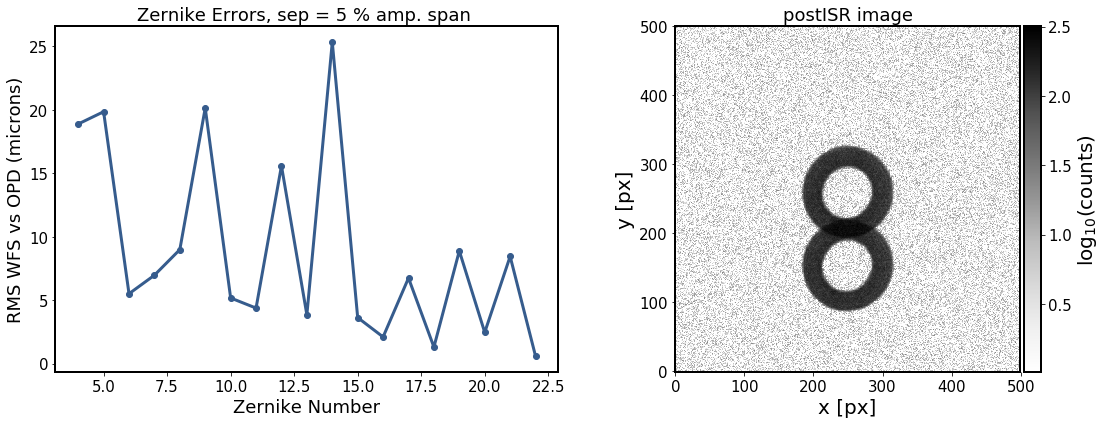

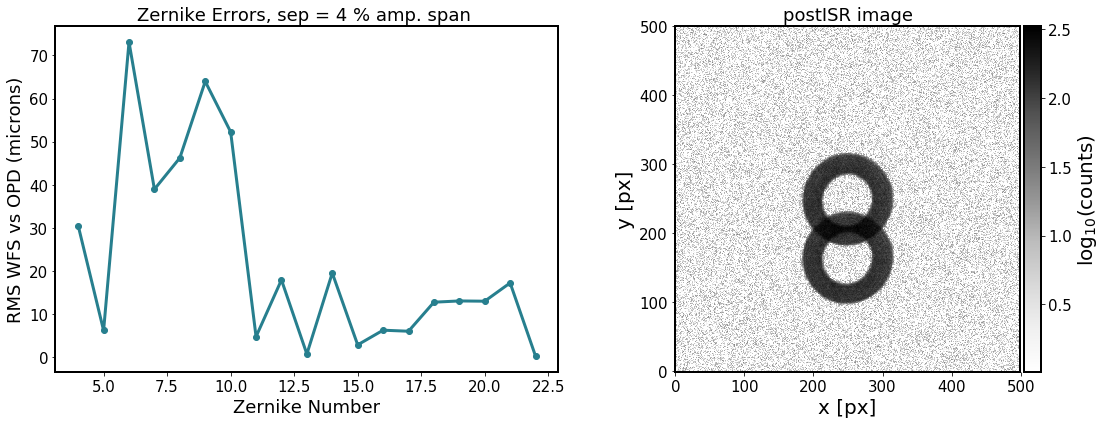

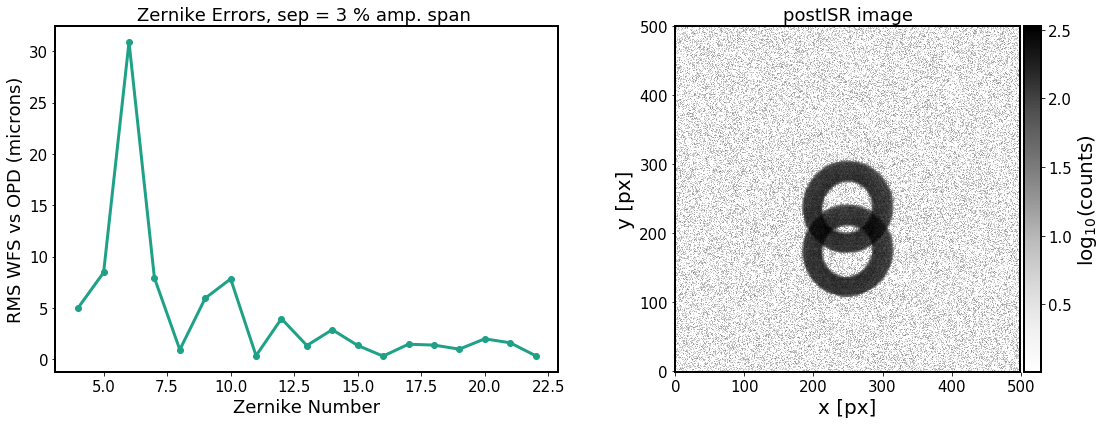

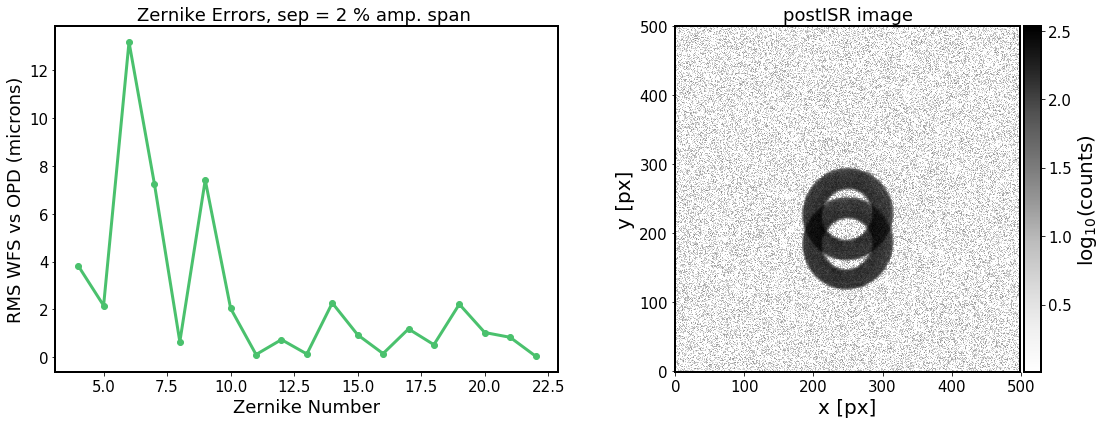

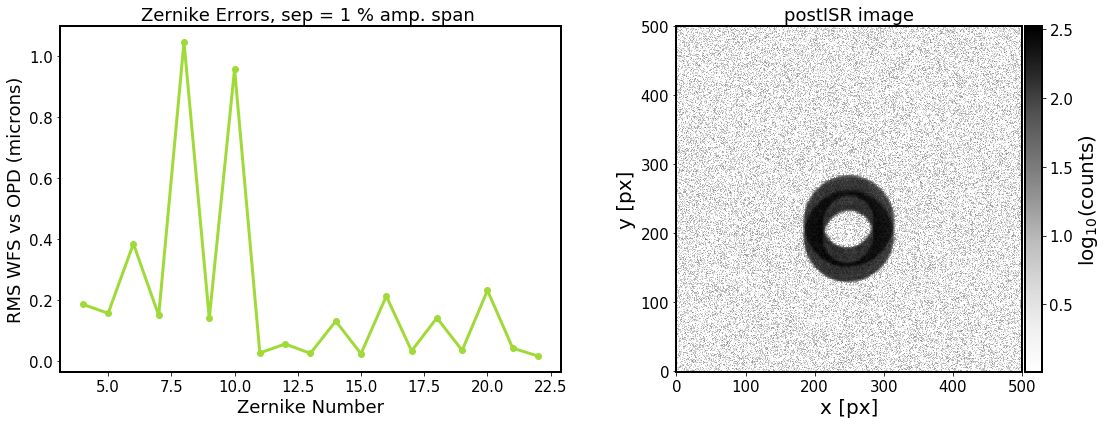

In [495]:
# print Zernikes and image data 

# select the actual donut position...
xmin,xmax = 1525,2025
ymin,ymax = 750,1250

#  plot the Zernikes 
for i in range(len(sepArr)):
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    
    ax[0].plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %d%%' % sepArr[i],color = cmap(colors[i]))

    ax[0].set_xlabel('Zernike Number', size=18)
    ax[0].set_ylabel('RMS WFS vs OPD (microns)', size=18)
    ax[0].set_title('Zernike Errors, sep = %d %% amp. span '%sepArr[i], size=18)
    
    # plot the postage stamp
    img = ax[1].imshow(np.log10(images[sepArr[i]][ymin:ymax, xmin:xmax]), vmin = 0.01,cmap=cm.get_cmap('Greys'),
              origin='lower')
    cbar= colorbar(mappable=img)
    cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')
    ax[1].set_title('postISR image')
    plt.tight_layout()
    plt.savefig('StarSep_singleAmp_rmswfs_opd_postIsr_sep%d.png'%sepArr[i],bbox_inches='tight',
               dpi=150)

## Fixed separation to 5%, vary magnitude of the companion star: 

Check how the results for the current deblender for a set separation (equal to 5% of amplifier ra span, i.e. 0.05*0.11735 deg = 0.0058675 deg = 21.123 asec), with one star set to magnitude of 16, and the other changing from 16 to 10 mag . 

In [502]:
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'


# Read in the Zernike comparison between wfs and opd 
# for a set separation ,but  a list of magnitudes 

#sepArr = [80,60,40,20,15,10,8,5,4,3,2,1]
#sepArr = [10,8,5,4,3,2,1]
sep = 5
#magArr = [16,15,14,13,12,11,10]
magArr = [14,13,12,11,10]

# initialize metrics class 
calcMagMetrics = calcMetrics()

N = len(magArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

# initialize storage arrays 
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

testLabel = 'mag'

for mag in magArr :
    testName  = '%s.%d' % (testLabel, mag)
    print(testName)
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.'+ testName)
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.'+ testName)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))



mag.14
mag.13
mag.12
mag.11
mag.10


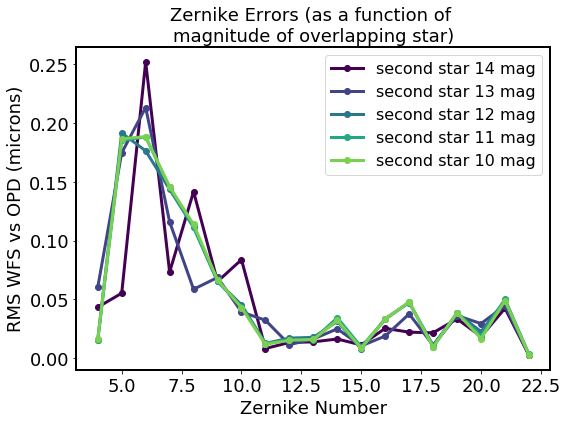

In [505]:

fig = plt.figure(figsize=(8,6))

for i in range(len(magArr)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='second star %d mag' % magArr[i],color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of \nmagnitude of overlapping star)', size=18)
    
plt.tight_layout()
plt.savefig('StarSep_singleAmp_sep5perc_varyMag_rms_wfs_vs_opd_1.png', bbox_inches='tight', 
           dpi=100)

Show the postage stamps used by deblender 



``` I think the postage stamp that you want to save to see if one donut appears on the stamp of another is **singleSciNeiImage** in this part of the code here: https://github.com/lsst-ts/ts_wep/blob/d32de1c93d067b48fb54dd0f4877d872e4b6f9e5/python/lsst/ts/wep/WepController.py#L367


If you add a line there to save that postage stamp and see what it looks like that might be helpful. That’s how I got the stamps in the Example Offset section of this notebook: https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_notebooks/centroid_accuracy.ipynb

Or maybe you can save **imgDeblend** here: https://github.com/lsst-ts/ts_wep/blob/d32de1c93d067b48fb54dd0f4877d872e4b6f9e5/python/lsst/ts/wep/WepController.py#L403

```

## Test varying magnitude *singleAmpMag* for overlapping sources before  centroid code updates: 

In [1]:
import numpy as np

mag.16
mag.15
mag.14
mag.13
mag.12


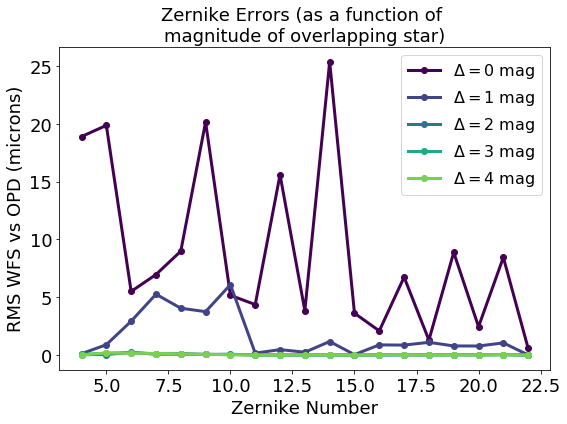

In [8]:
baseDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_after_centroid_update'
resDir = 'singleAmpMag'
data_dir = os.path.join(baseDir, topDir,resDir)


# Read in the Zernike comparison between wfs and opd 
# for a set separation ,but  a list of magnitudes 

sep = 5
#magArr = [16,15,14,13,12,11,10]
magArr = [16,15,14,13,12]

# initialize metrics class 
calcMagMetrics = calcMetrics()

N = len(magArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

# initialize storage arrays 
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

testLabel = 'mag'

for mag in magArr :
    testName  = '%s.%d' % (testLabel, mag)
    print(testName)
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.'+ testName)
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.'+ testName)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))




fig = plt.figure(figsize=(8,6))

for i in range(len(magArr)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label=r'$\Delta =%d$ mag ' % (16-magArr[i]),color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of \nmagnitude of overlapping star)', size=18)
    
plt.tight_layout()
plt.savefig('StarSep_singleAmp_sep5perc_varyMag_rms_wfs_vs_opd_1.png', bbox_inches='tight', 
           dpi=100)

In [12]:
import numpy

## Test separation  *singleAmpSep* on a single amplifier before the centroid code updates (and having saved all postage stamp images):

10
9
8
7
6
5
4
3
2
1
10
9
8
7
6
5
4
3
2
1


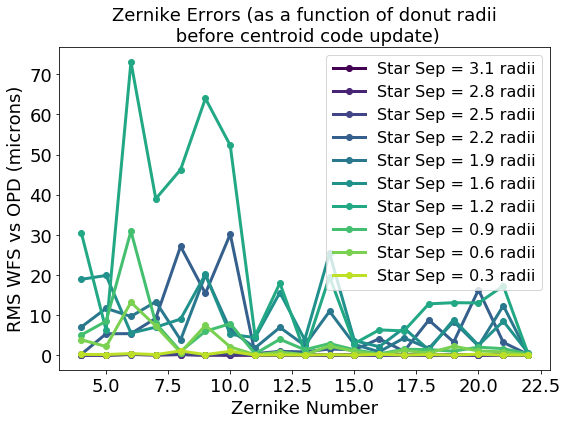

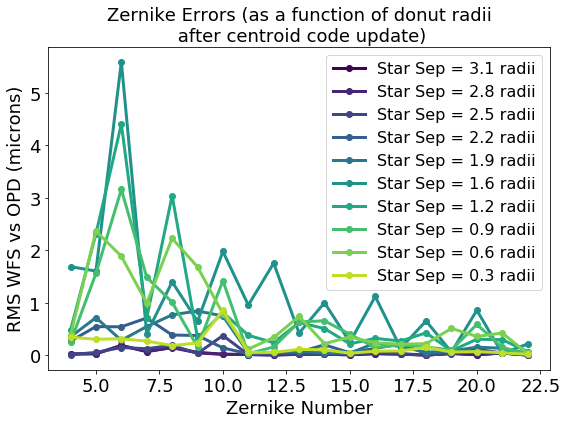

In [14]:
%matplotlib inline

baseDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'

for when in ['before', 'after'] : # the centroid code update
    topDir = 'results_'+when+'_centroid_update'
    resDir = 'singleAmpSep'
    data_dir = os.path.join(baseDir, topDir,resDir)


    ssrTotalVals = []
    ssrFieldVals = []
    zernikeErrors = []

    calcMagMetrics = calcMetrics()

    #sepArr = [80,60,40,20,15,10,8]#,
    sepArr = [10,9,8,7,6,5,4,3,2,1]
    #sepArr = [10,1]

    yPxAmp = 2048 # in pixeels
    donutPxRadius = 66 # px 

    N = len(sepArr)
    colors = (np.arange(N+1)/N) 
    cmap = cm.get_cmap('viridis') 


    for sep in sepArr :
        print(sep)
        opdZkFilePath = os.path.join(data_dir, 'opd.zer.sep.%d'%sep)
        wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.sep.%d'%sep)
        opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
        opdData = opdData[:3]
        wfsData = wfsData[:3]
        zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))


        # calculate sum of squared residuals : 
        # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
        # zerTotalSSR = np.sum(zerFieldSSR)
        zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
        ssrFieldVals.append(zerFieldSSR)
        ssrTotalVals.append(zerTotalSSR)

    zernikeErrors = np.array(zernikeErrors)
    zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


    fig = plt.figure(figsize=(8,6))

    for i in range(len(sepArr)):
        sepInPx = sepArr[i]*0.01*yPxAmp
        plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
                 '-o', lw=3, label='Star Sep = %.1f radii' % (sepInPx / donutPxRadius),color = cmap(colors[i]) )
        plt.xlabel('Zernike Number', size=18)
        plt.ylabel('RMS WFS vs OPD (microns)', size=18)
        plt.xticks(size=18)
        plt.yticks(size=18)
    plt.legend(fontsize=16)
    plt.title('Zernike Errors (as a function of donut radii\n %s centroid code update)'%when, size=18)

    plt.tight_layout()
    plt.savefig('StarSep_'+when+'_singleAmp_16mag_vary_separation_rms_wfs_vs_opd_overlapping_in_donut.png', 
                bbox_inches='tight', 
               dpi=100)